PCA & Monte Carlo Simulation for Vasicek Interest Rate Model

Interest rate models are mainstay for risk and asset managers, in particular for those overseeing long term investments. We are aware of the fact that, interest rates affect all levels of economic activities and it is quite well known that, Central banks of most of the countries target interest rates as a policy tool to influence economic activity.

There are several interest rate models have been proposed for financial studies e.g Vasicek model, CIR model, and Hull-White model. Mostly involve modeling the short rate and rely on factors with most of them using only one factor. Two-factor and multifactor interest rate models have been proposed. Vasicek suggests that short-term interest rate would revert to a certain level in a long run and suggested to use Ornstein-Uhlenbeck process to model the mean reversion property of interest rate.

Here, we will implement PCA and a Vasicek short-rate model for swap rates, treasury rates and the spread between these two. Vasicek interest rate model is quite popular among the practitioners due to the interpretability of its parameters and the parsimonious setup. It has extensive use to determine bond, option, prices, and the hedge parameters. We will also provide a calibration procedure of the Vasicek model.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,6)
plt.style.use("dark_background")
import seaborn as sns
import quandl

            SWAP1  SWAP2  SWAP3  SWAP4  SWAP5  SWAP7  SWAP10  SWAP30
DATE                                                                
2000-07-03   7.10   7.16   7.17   7.17   7.17   7.20    7.24    7.24
2000-07-05   7.03   7.06   7.07   7.07   7.08   7.11    7.14    7.16
2000-07-06   7.07   7.13   7.14   7.15   7.16   7.19    7.21    7.21
2000-07-07   7.01   7.04   7.06   7.06   7.07   7.10    7.14    7.14
2000-07-10   7.04   7.09   7.11   7.13   7.14   7.17    7.20    7.19


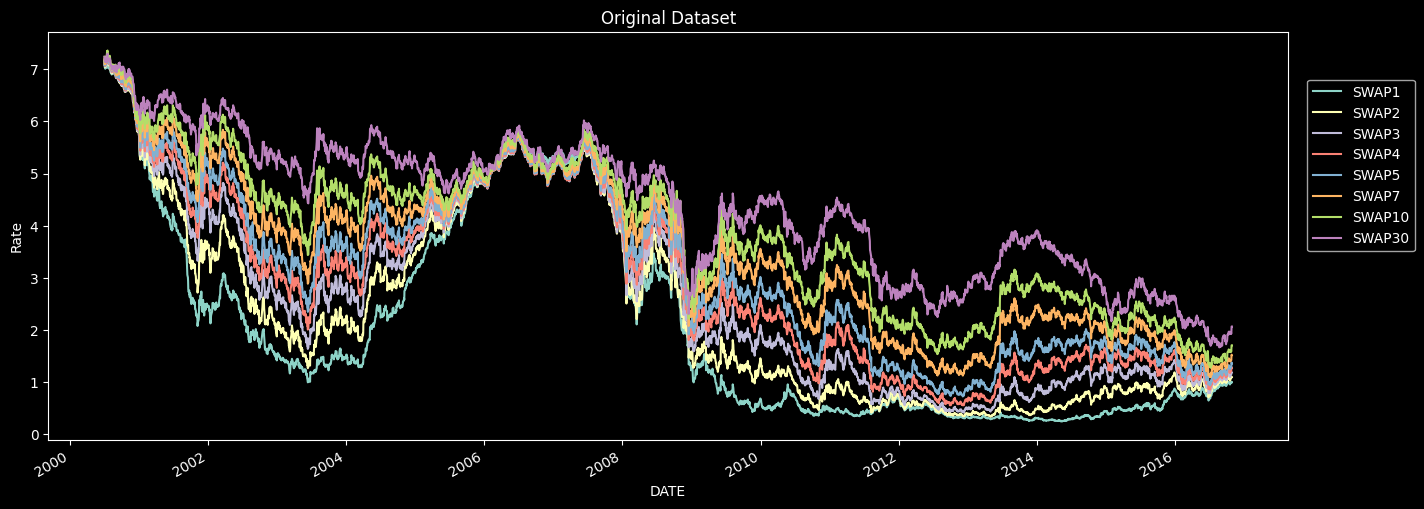

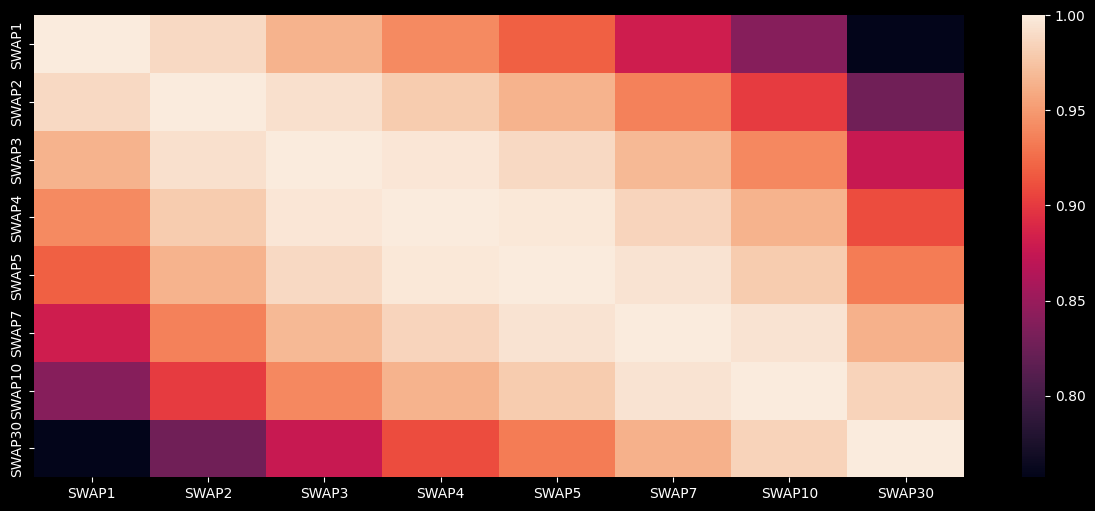

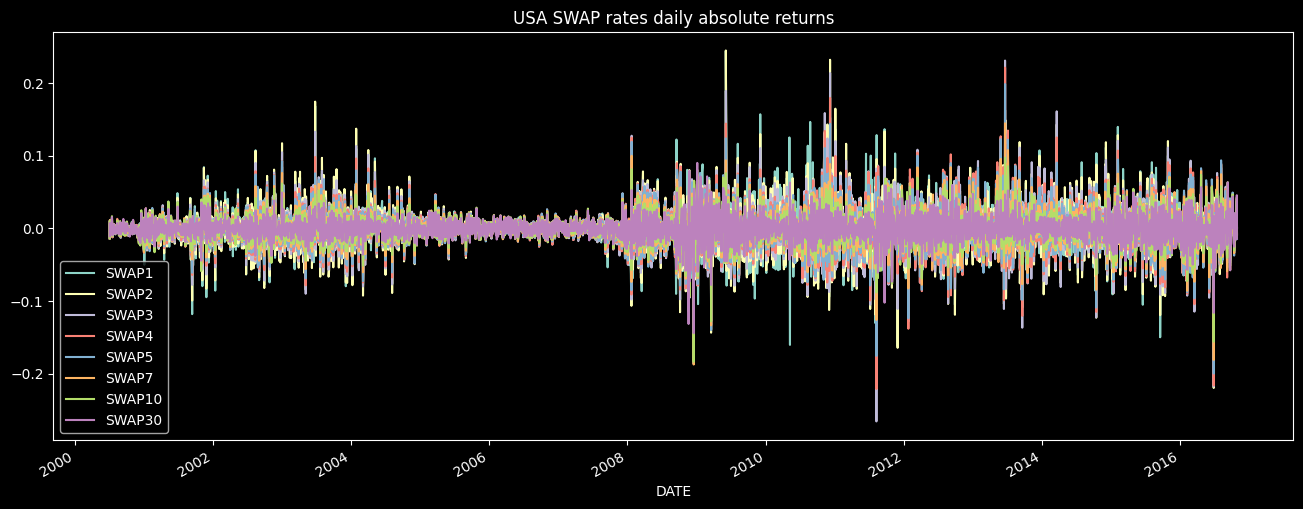

In [4]:
quandl.ApiConfig.api_key = "Your api here"
swap_names = ['FRED/DSWP1',
             'FRED/DSWP2',
             'FRED/DSWP3',
             'FRED/DSWP4',
             'FRED/DSWP5',
             'FRED/DSWP7',
             'FRED/DSWP10',
             'FRED/DSWP30']

swap_df = quandl.get(swap_names)
swap_df = swap_df.dropna()
swap_df.columns = ["SWAP1",
                  "SWAP2",
                  "SWAP3",
                  "SWAP4",
                  "SWAP5",
                  "SWAP7",
                  "SWAP10",
                  "SWAP30"]
print(swap_df.head())
swap_df2 = swap_df.copy()
swap_df.plot(figsize=(16,6))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.title("Original Dataset")
plt.show()
sns.heatmap(swap_df.corr())
plt.show()
df1_returns = swap_df.pct_change()
df1_returns.plot(figsize=(16,6))
plt.title('USA SWAP rates daily absolute returns')
plt.show()

Here we see that, returns are highly correlated across the maturities and fairly stationary. Since the correlation between yields is so high, we may run into the problem of multicollinearity; let us get into factor analysis.

Principal Component Analysis:

PCA (unsupervised learning technique) uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first loading points in the direction where data has the largest variance. One of the key features of PCA is the ability to reconstruct the initial dataset using the outputs of PCA.

Why PCA? A portfolio of bonds is sensitive to changes in interest rates for different maturities. By applying PCA, we will extract a number of unobservable factors (first n factors explaining most of the variation in the data) which drive the interest rates.

Let us find out the optimal number of components to retain 99% variance in the data. Mathematically, PCA depends upon the eigen-decomposition of positive semi-definite matrices and upon the singular value decomposition (svd) of rectangular matrices.

Projection onto Principal Components

In [5]:
def PCA(df, num_reconstruct):
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecs
scores, evals, evecs = PCA(swap_df, 7)
evalsum=sum(evals)
evalPercent=[]

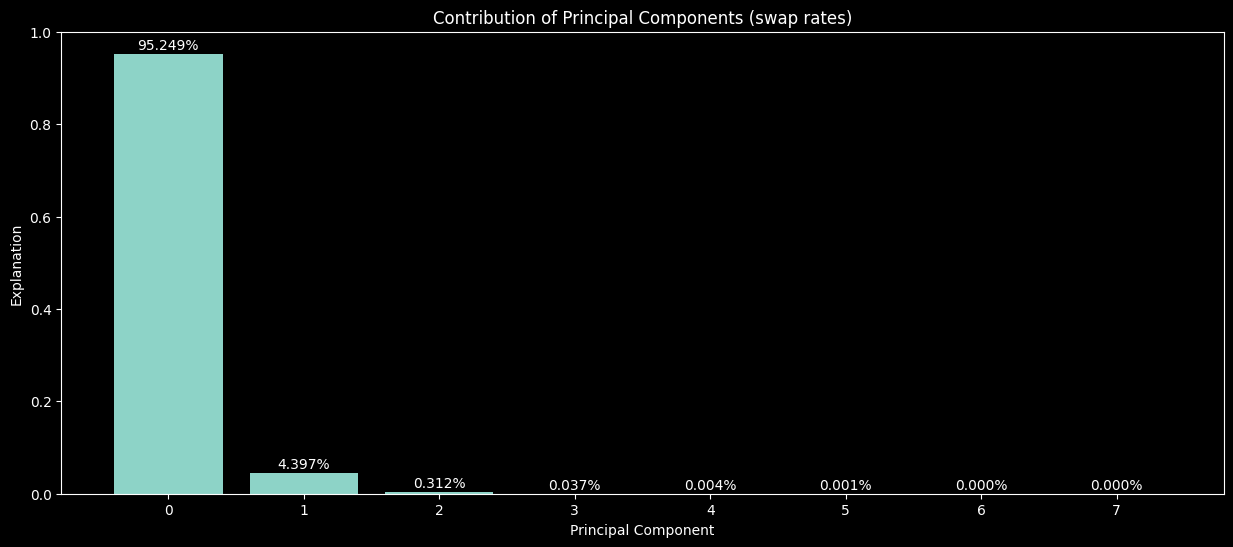

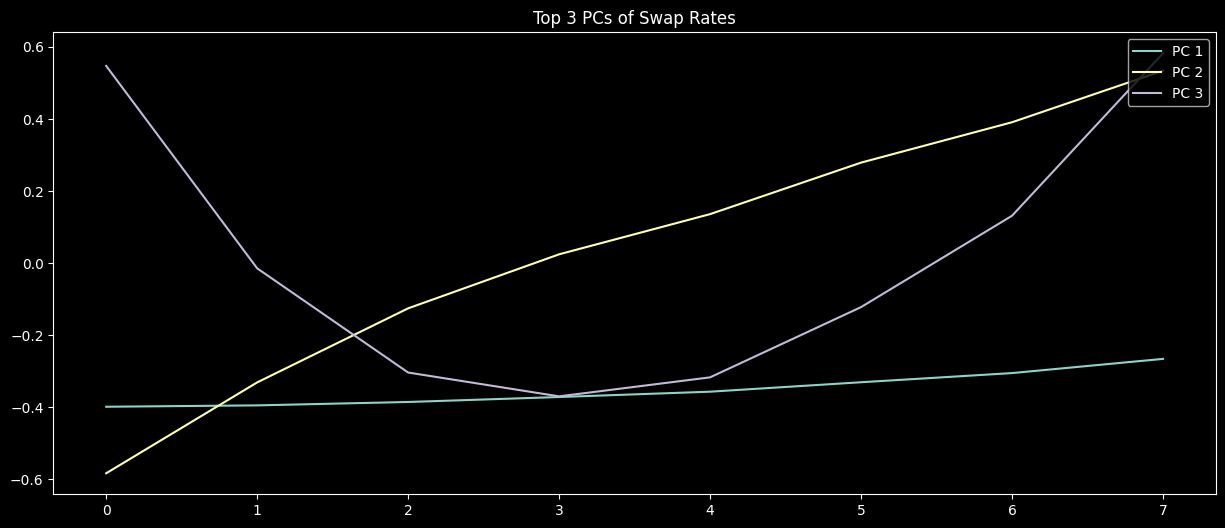

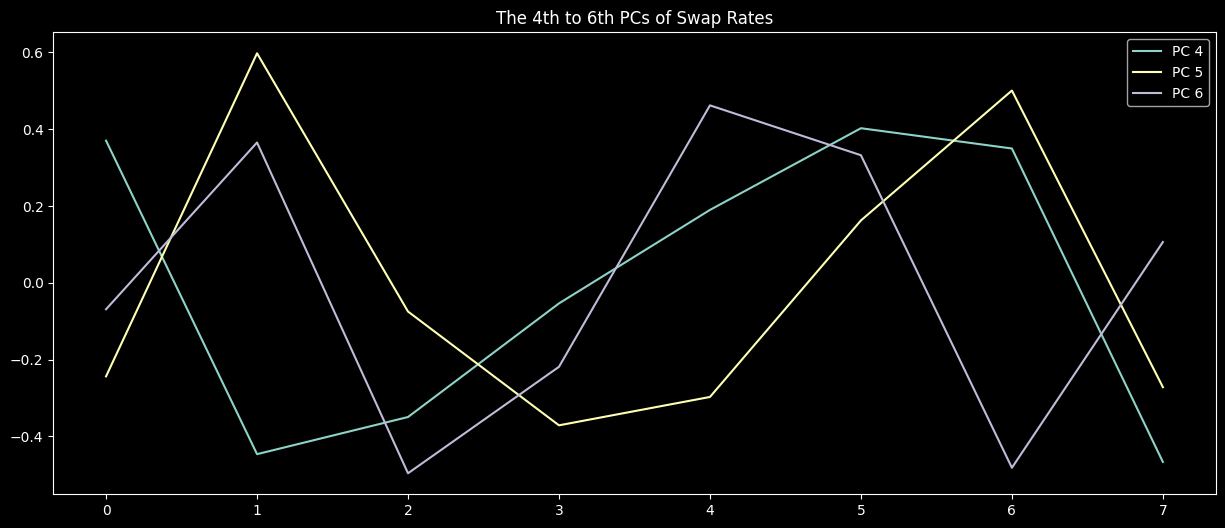

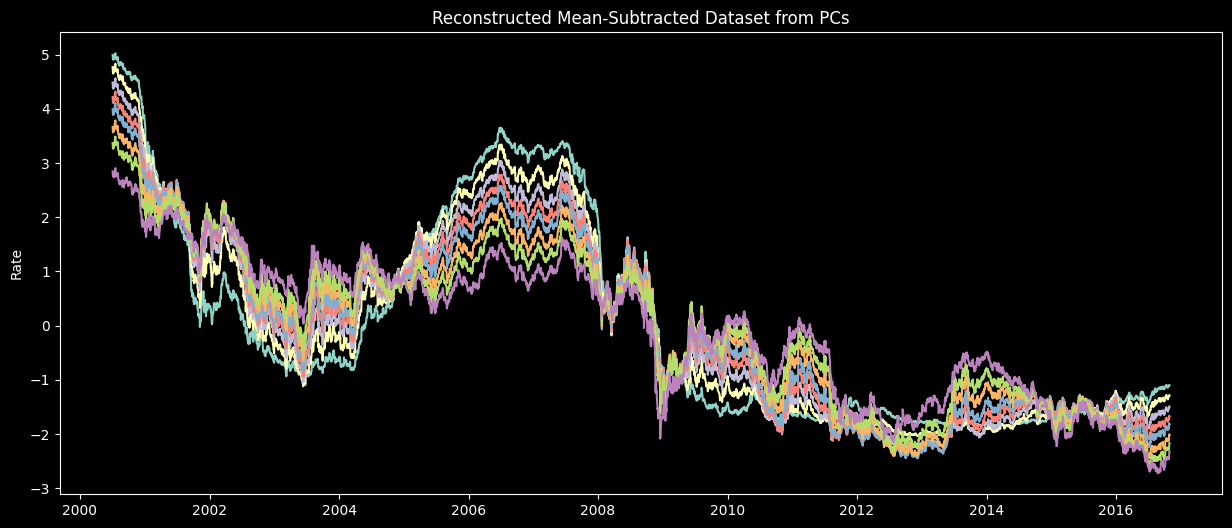

In [6]:
for value in evals:
    # Add the value to the new list
    evalPercent.append(value/evalsum)
plt.bar(range(len(evalPercent)), evalPercent)
for i, v in enumerate(evalPercent):
    plt.text(i, v + 0.01, "{:.3%}".format(v), ha='center')
# Add labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explanation')
plt.title('Contribution of Principal Components (swap rates)')
plt.show()
evecs = pd.DataFrame(evecs)
for i, col in enumerate(evecs.loc[:, 0:2]):
    plt.plot(evecs[col], label=f'PC {i+1}')
plt.legend()
plt.legend(loc='upper right')
plt.title('Top 3 PCs of Swap Rates')
plt.show()
for i, col in enumerate(evecs.loc[:, 3:5]):
    plt.plot(evecs[col], label=f'PC {i+4}')
plt.legend()
plt.legend(loc='upper right')
plt.title('The 4th to 6th PCs of Swap Rates')
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=swap_df.index, columns=swap_df.columns)

plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset from PCs")
plt.show()

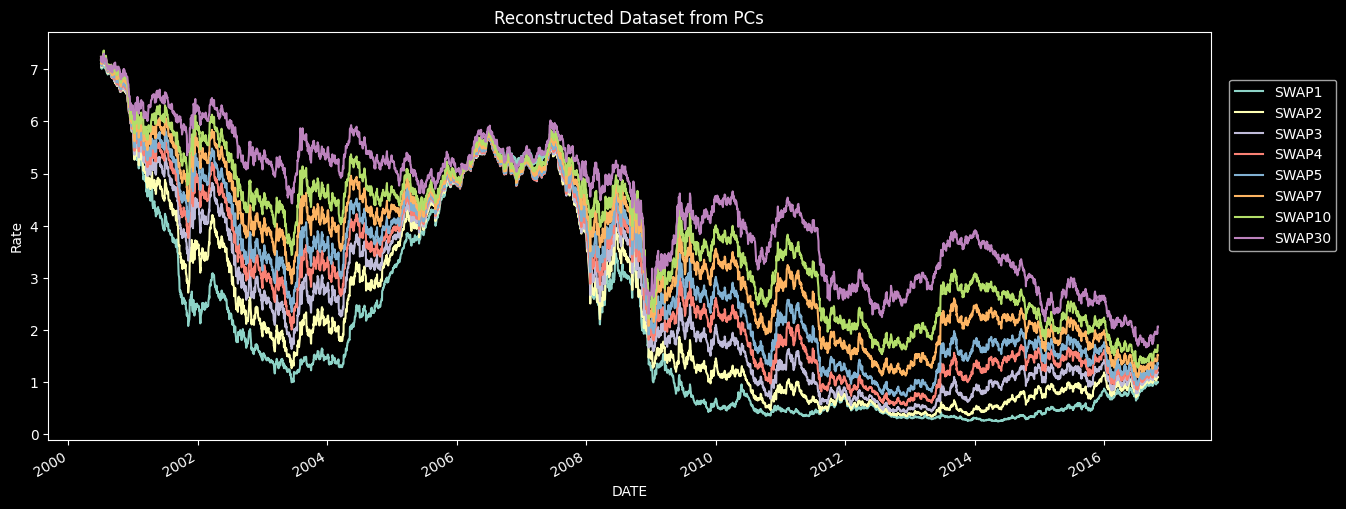

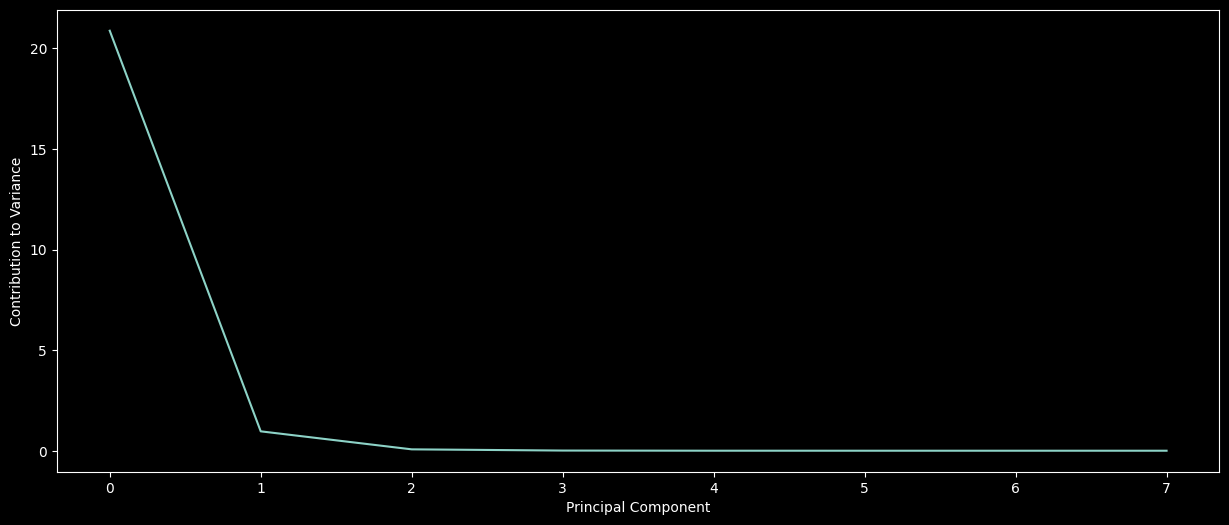

In [7]:
for cols in reconst.columns:
    reconst[cols] = reconst[cols] + swap_df2.mean(axis=0)[cols]

reconst.plot(figsize=(15,6))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.title("Reconstructed Dataset from PCs")
plt.show()

plt.plot(evals)
plt.ylabel("Contribution to Variance")
plt.xlabel("Principal Component")
plt.show()

We can see that, PC1 explains over 96% of the total variation, and PC2 explains close to 3.37% of total variation and combining over 99%. Therefore, rather than using all PCs in the subsequent calculation, we will only use PC1 and PC2 in further calculation as these t of total variance.

PC1 corresponds to the roughly the parallel shift in the yield curve.
PC2 corresponds to roughly a steepening in the yield curve.
This is in-line with the theory of fixed income risk measurement which states that majority of the movement in the price of a bond is explained by the parallel shift in the yield curve; parallel shift in the yield curve represent a change in the general level of interest rates in the economy.

Interest rates are more complex compared to share price and they are not just a prices, for many products, we need a complete yield curve. Here, we cannot explain an yield curve by just a number but a set of continuous numbers. More so, volatility varies along the length of the curve. On the top of that, there are discounts the price to consider.

By plotting the components of the eigenvectors we can identify them with

the first eigenvector has all components positive (parallel level shift),
the second eigenvector has the first half of the components positive and the second half negative (slope tilt),
the third eigenvector has the first third of the components positive, second third negative, and the last third positive (flexing).

We see here that, the largest variance comes from a parallel shift in the curve, the second largest variance comes from a tilt of the curve, and the third largest variance comes from a flexing of the curve.

Yield curves:
Long-term interest rates are higher than short-term interest rates in a normal yield curve environment. This means that, investors are likely to be compensated with higher returns for a longer period since they are exposed to higher default risk. The normal or positive yield curve is said to be upward sloping.

However, in certain economic conditions when the supply of money is tight, the curve can be downward sloping. Long-term interest rates are lower than short-term interest rates. Investors are willing to forgo long-term gains to preserve their wealth in the short term. During periods of high inflation, where the inflation rate exceeds the rate of coupon interests, negative interest rates may be observed. Investors are willing to pay in the short term just to secure their long-term wealth.

Treasury Rates:

The same method is implemented for the constant maturity treasury rates. Let us initialize PCA to reduce the data up to the number of components that explains 99% of the variance.

In [8]:
import sklearn.decomposition as PCA

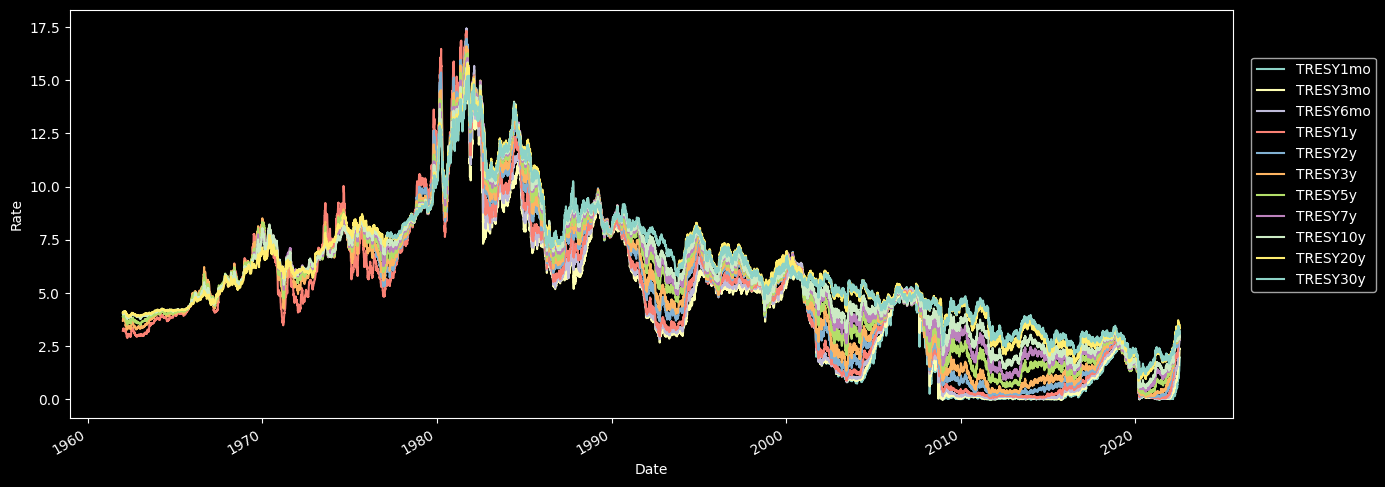

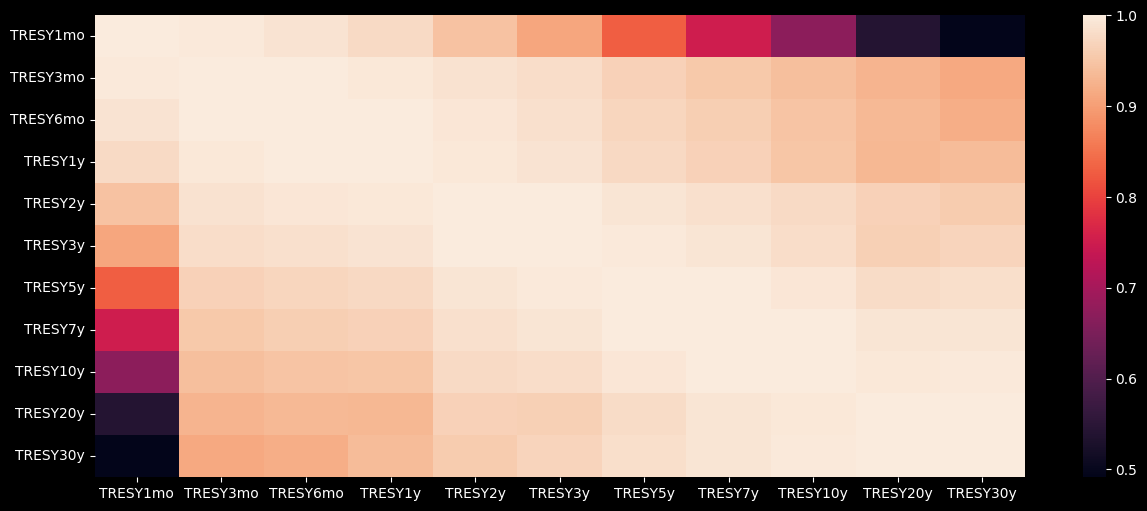

In [15]:
treasury = ['FRED/DGS1MO',
           'FRED/DGS3MO',
           'FRED/DGS6MO',
           'FRED/DGS1',
           'FRED/DGS2',
           'FRED/DGS3',
           'FRED/DGS5',
           'FRED/DGS7',
           'FRED/DGS10',
           'FRED/DGS20',
           'FRED/DGS30']

treasury_df = quandl.get(treasury)
treasury_df.columns = ['TRESY1mo',
                    'TRESY3mo',
                    'TRESY6mo',
                    'TRESY1y',
                    'TRESY2y',
                    'TRESY3y',
                    'TRESY5y',
                    'TRESY7y',
                    'TRESY10y',
                    'TRESY20y',
                    'TRESY30y']
treasury_df.plot(figsize=(15,6))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01,.9), loc=2)
plt.show()
sns.heatmap(treasury_df.corr())
plt.show()

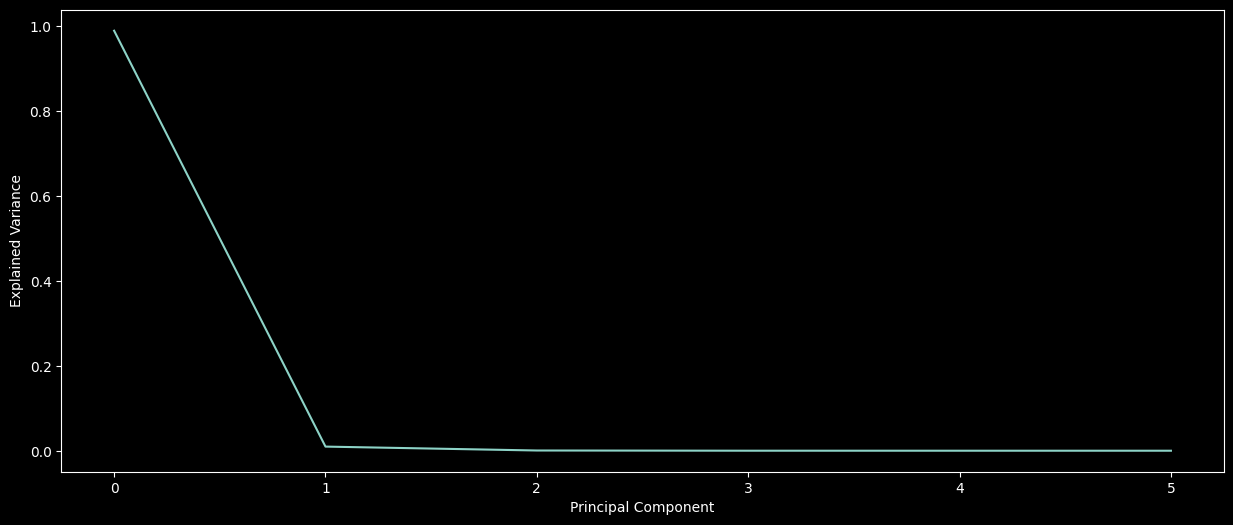

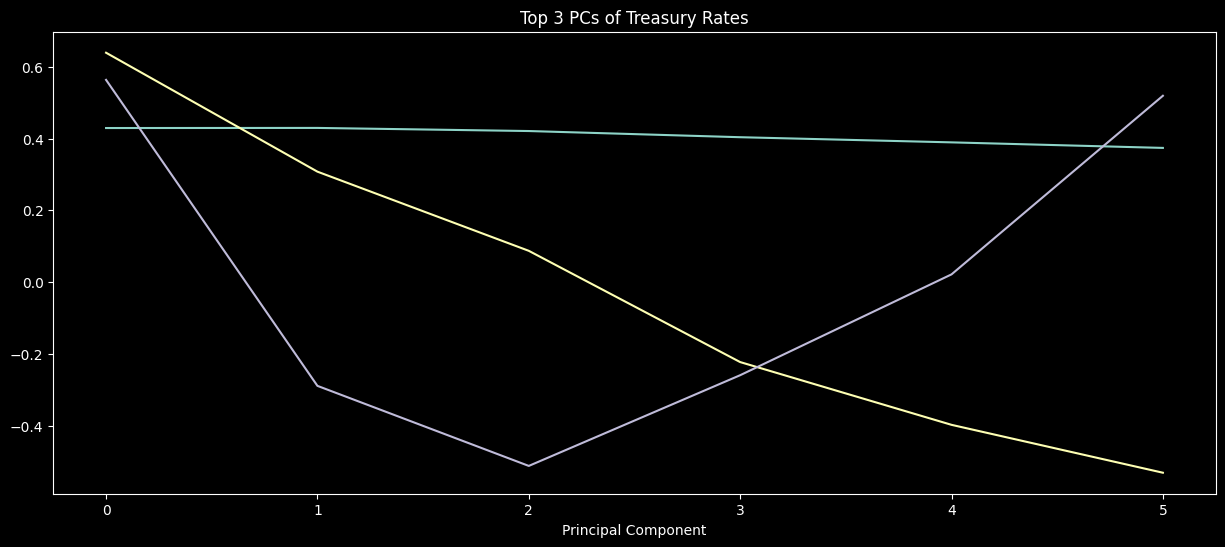

In [10]:
treasury_df = treasury_df.astype(float)
treasury_df2 = treasury_df.iloc[:, 3:-2]
treasury_df2 = treasury_df2.dropna()
comb_df = treasury_df2.merge(swap_df2, left_index=True, right_index=True)
pca_t = PCA.PCA(n_components=6)
pca_t.fit(treasury_df2)
PCA.PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
plt.plot(pca_t.explained_variance_ratio_)
plt.ylabel("Explained Variance")
plt.xlabel("Principal Component")
plt.show()

plt.plot(pca_t.components_[0:3].T)
plt.title('Top 3 PCs of Treasury Rates')
plt.xlabel("Principal Component")
plt.show()

Swap Spreads:

We can observe almost similar PCA results between the swap rates and treasury rates. Let us investigate the spread between these two rates. Swap spreads are the difference between the swap rate (a fixed interest rate) and a corresponding government bond yield with the same maturity (Treasury securities in the case of the United States).

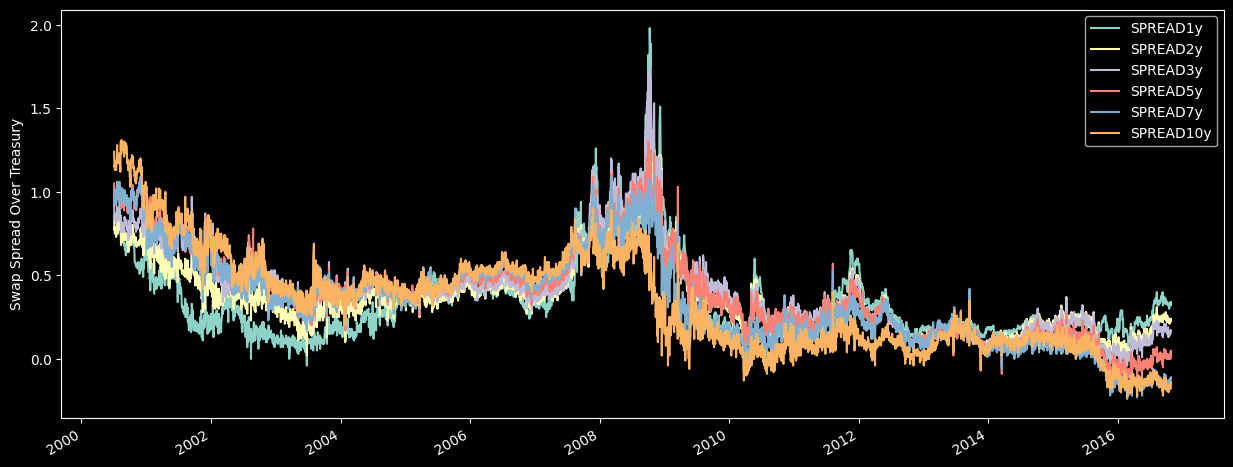

In [11]:
spread = [comb_df.SWAP1-comb_df.TRESY1y,
        comb_df.SWAP2-comb_df.TRESY2y,
       comb_df.SWAP3-comb_df.TRESY3y,
       comb_df.SWAP5-comb_df.TRESY5y,
       comb_df.SWAP7-comb_df.TRESY7y,
       comb_df.SWAP10-comb_df.TRESY10y]
spread_df = pd.DataFrame(np.array(spread).T, index=comb_df.index,
                         columns = ["SPREAD1y", "SPREAD2y", "SPREAD3y", "SPREAD5y", "SPREAD7y", "SPREAD10y"])
spread_df.plot()
plt.ylabel("Swap Spread Over Treasury")
plt.show()

We are aware of the fact that, interest rate processes are in general defined through stochastic differential equation. Vasicek’s model was the first one to capture mean reversion, an essential characteristic of the interest rate that sets it apart from simpler models. This is because of the simple fact that, interest rates are not expected to rise indefinitely because at very high levels that would hamper economic activity, prompting a decrease in interest rates. Likewise, interest rates are unlikely to decrease indefinitely. As a result, interest rates move mainly in a range, showing a tendency to revert to a long run value.

Rates Simulation:
Let us simulate various trajectories of the yield spread using the Vasicek model, by changing its various parameter. We will use a basic stochastic model (Vasicek short-rate model) to simulate out spreads. Considering interest rate process is a general stochastic differential equation, the typical implementation uses MLE to derive out the key parameters of the following mean reversion model:

dr(t) = κ(θ − r(t))dt + σdW(t)

dr is the change in interest rate
κ = speed at which the yield spread rates revert to the mean θ; this will create convergence
t=Time period
θ = Long-term level of the mean
σ = volatility or the standard deviation of the current interest rate at time t, it will create randomness; here noise term is normally distributed.
rt short rate (yield spread) at time t
κ(θ − rt ) = Expected change in the interest rate at time t (the drift factor, also known as the mean reversion for Vasicek model.
dt = change in time or the length of time interval.
W = Random market risk (represented by a Wiener process)
[κ(θ − r(t))dt] is known as the drift component and [σdW(t)] is known as the volatility component.

Here, the mean reversion property means, if the interest rate is bigger than the long run mean (rt > θ) , then the model pulls it down as drt =κ(θ - rt) < 0, and if rt < θ then it is pushed up as drt = κ(θ − rt) >0. Estimating the expected yield spread rates, the Vasicek model calibrates the weighted average between the yield spread currently at time t and the expected long-term value θ.

We will apply Vasicek Model close form solution for rt to avoid discretization errors. Vasicek follows Ornstein-Uhlenbeck process, where the model reverts around the mean theta with κ. The mean reversion or mean half-life is the expected time for the process to return halfway to its long term mean, and can be computed as half life = ln(2)/κ.

If we know all three factors κ, θ and σ, we can use the formula to forecast the interest rate movements. Now, how do we decide the parameters K, θ and σ? The basic approach is to calibrate κ, θ and σ based on a historical dataset and then use it in Monte Carlo modelling of rate paths.

In [12]:
def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):
    # Implements above closed form solution
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out
def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    short_r = [0]*N # Create array to store rates     short_r[0] = r0 # Initialise rates at $r_0$
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    return short_r
def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    sim_arr = np.ndarray((N, M))
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    return sim_arr
def VasicekCalibration(rates, dt=1/252):
    n = len(rates)
    # Implement MLE to calibrate parameters
    Sx = sum(rates[0:(n-1)])
    Sy = sum(rates[1:n])
    Sxx = np.dot(rates[0:(n-1)], rates[0:(n-1)])
    Sxy = np.dot(rates[0:(n-1)], rates[1:n])
    Syy = np.dot(rates[1:n], rates[1:n])
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates[n-1]
    return [kappa, theta, sigma, r0]
params = VasicekCalibration(spread_df.loc[:, 'SPREAD10y'].dropna()/100)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]
print(f"\n\nCalibrated parameters: kappa={kappa:.3f}  theta={theta:.3f}  sigma={sigma:.3f}  r0={r0:.3f}")
years = 1
N = years * 252
t = np.arange(0,N)/252



Calibrated parameters: kappa=4.222  theta=0.003  sigma=0.009  r0=-0.002


For the simulation we assume that we have 252 discrete hedge points (which is roughly the amount of trading days in a year). We can observe, the interest rates did become negative at some point.

Monte Carlo Simulation:
Monte Carlo simulations are path dependent, so at any time it knows the whole past history but not the future. Simulating starting from r0 = last_Observed_Value and generate a sequence of trajectories of the yield spread in each of the graphs below. We have assumed that the long-run yield spread, θ = 0.29%, which is the mean of the data. Here, we will generate a sequence of 10 trajectories of the yield spread in each of the graphs below.

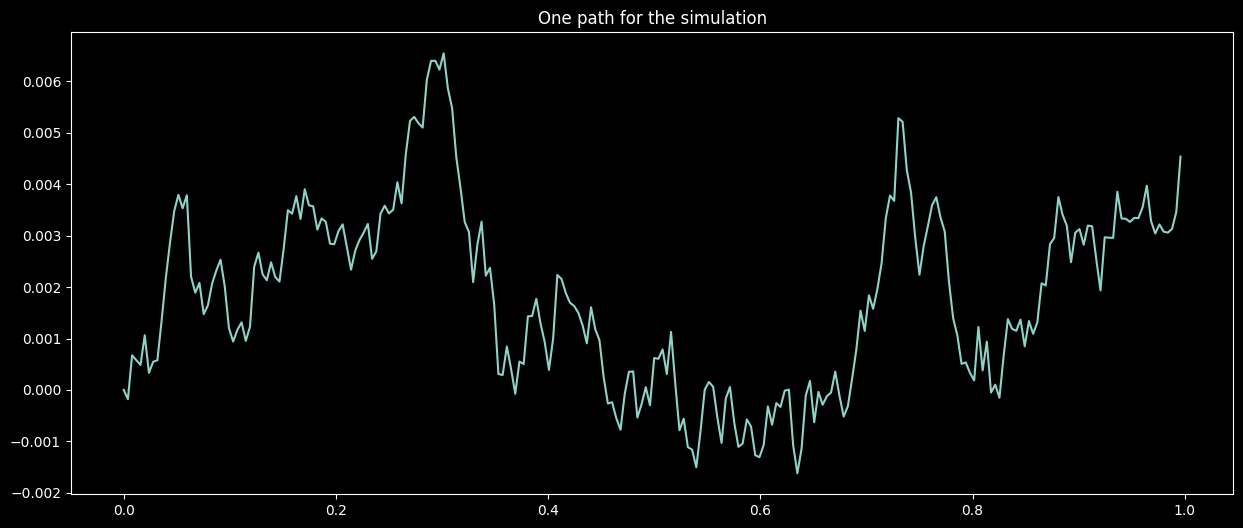

In [13]:
test_sim = VasicekSim(N, r0, kappa, theta, sigma, 1/252)
plt.plot(t,test_sim)
plt.title("One path for the simulation")
plt.show()
M = 100
rates_arr = VasicekMultiSim(M, N, r0, kappa, theta, sigma)

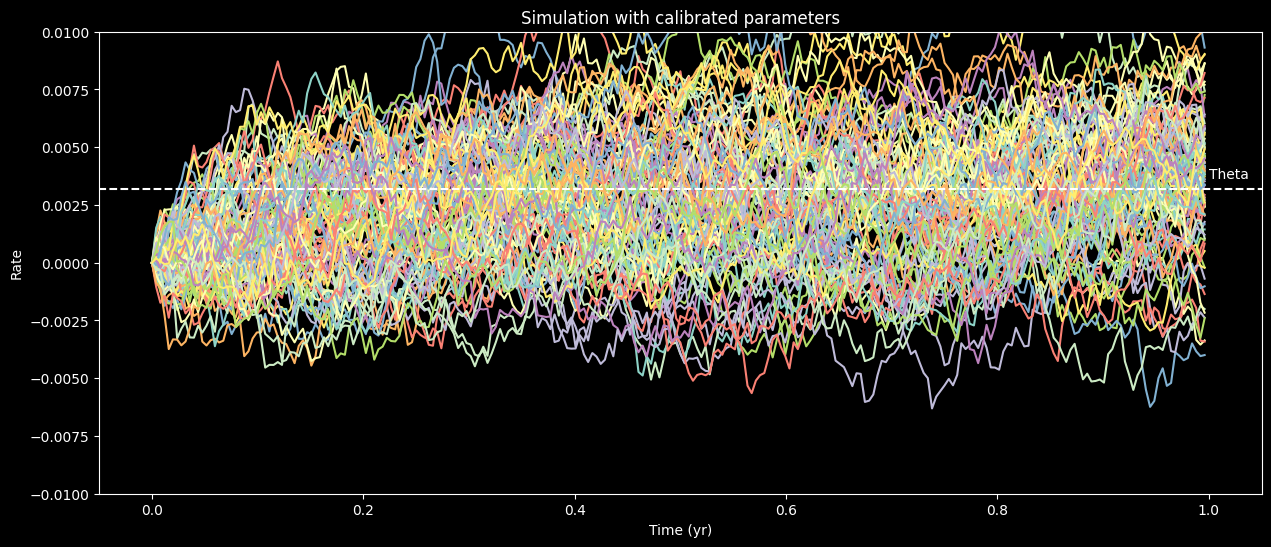

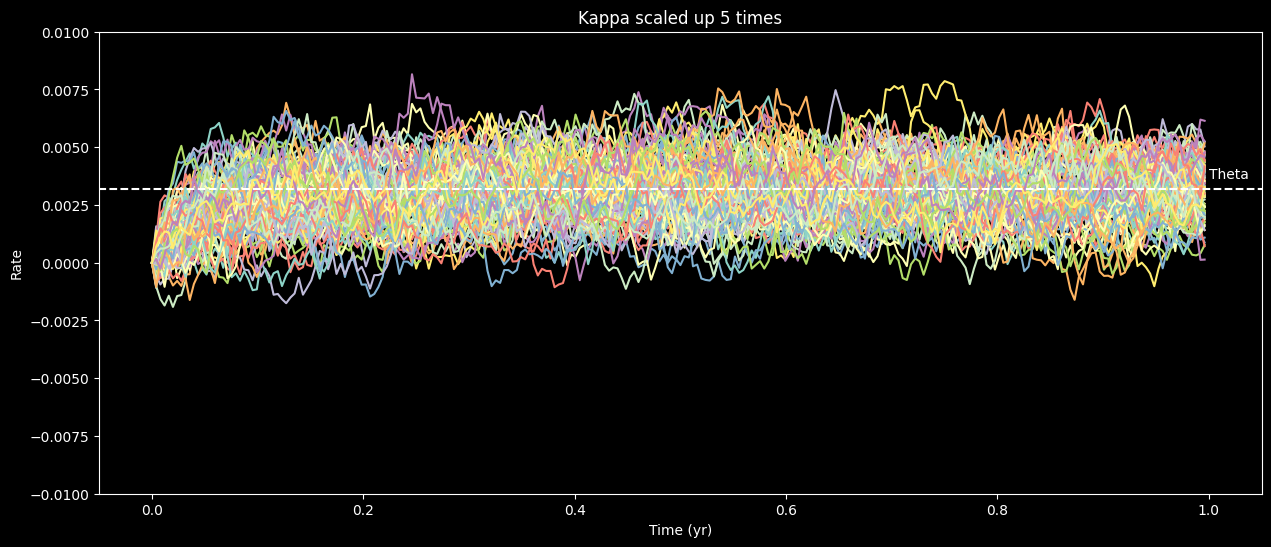

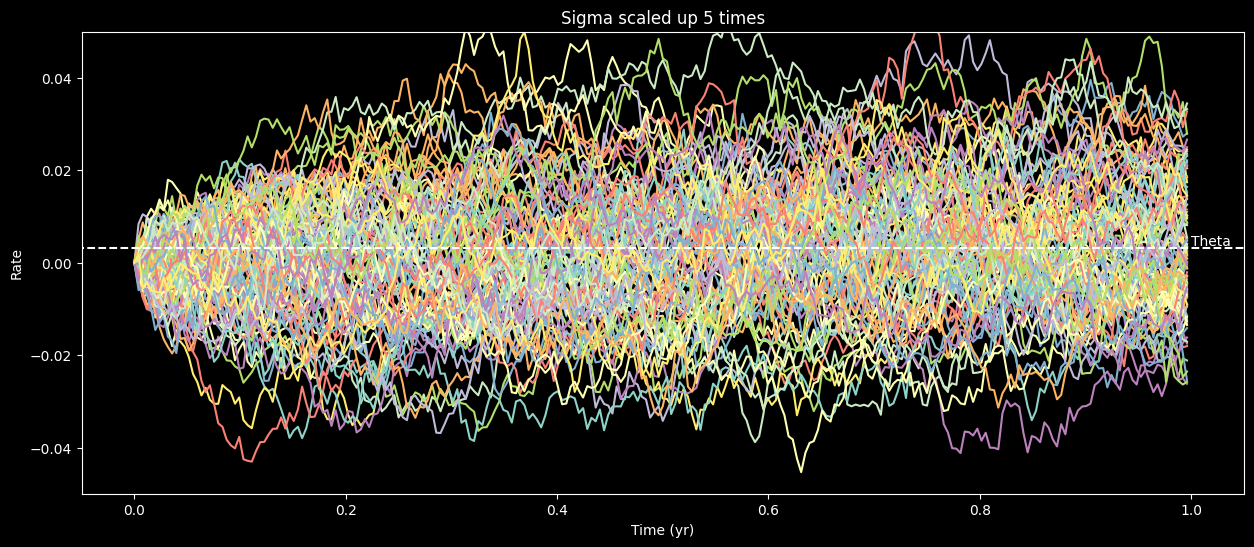

In [14]:
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylim([-0.01, 0.01])
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.title("Simulation with calibrated parameters")
plt.show()

M = 100
rates_arr = VasicekMultiSim(M, N, r0, kappa*5, theta, sigma)
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylim([-0.01, 0.01])
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.title("Kappa scaled up 5 times")
plt.show()
M = 100
rates_arr = VasicekMultiSim(M, N, r0, kappa, theta, sigma*5)
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylim([-0.05, 0.05])
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.title("Sigma scaled up 5 times")
plt.show()

We observe the model’s mean-reverting nature by specifying r0 further away from θ. Over time this pulls the yield spread towards θ , the magnitude of K controls the speed of the reversion. As K grows, mean reversion quickens. Likewise, larger σ widens the volatility and the potential distribution rate.

Increasing the speed of the mean reversion intensifies the pace at which yield spread converges to its long-run level θ . Below, when σ shoots up by 5 times, volatility rises, increasing the fluctuations in the ex-ante paths of yield spread, making it harder to converge to the θ level of yield spread.

Thus, knowing the long-run value of the short-term yield spread rates θ and the mean-reversion adjustment rate K enables us to calculate the evolution of the yield spread rates using the Vasicek model.

Now talking about risk, financial institutions such as banks are increasingly facing risk in various financial instruments which includes interbank transactions, trade financing, forex transactions, futures, swaps, bonds, equities, options etc. to name a few. Therefore, it is extremely important to have a sound risk management practice and compliance to BASEL regulation to stay afloat in financial business.

Key takeaways:
In both models (PCA & Vasicek), we have experimented with more than one factor in fitting the term structure of the yield curve to assess the number of factors necessary in characterizing the yield curve. We observed that, increasing the number of factors improved the fit of the estimated yield curve to the observed data.

Mean reversion as observed in Vasicek interest rate model is undeniable. We have seen that, in Vasicek Model model where the short-term interest rate converges to a steady state value (r0). This means that, when the rates are high, the economy tends to slow down which leads to borrowers require less funds. On the contrary when the rates are low, there tends to be high demand for funds on the part of the borrowers and rates tend to increase. Without this feature, interest rates could drift permanently upward and behave similar like stock prices do.